In [3]:
# Install SAM and necessary dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

  Preparing metadata (setup.py) ... done


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

torch.cuda.is_available()

Mounted at /content/drive


True

In [5]:
# CHECKPOINT downloading
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-07-16 07:10:27--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   116MB/s    in 20s     

2024-07-16 07:10:47 (120 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [6]:
# Define model type and checkpoint path
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"

# Load the model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Init mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

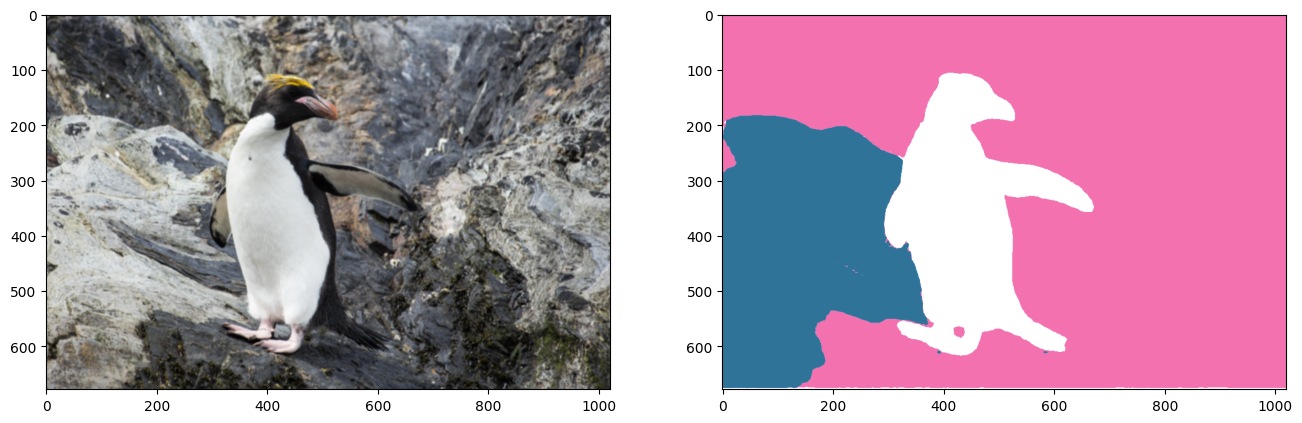

In [7]:
# https://www.freecodecamp.org/news/use-segment-anything-model-to-create-masks/

# Give the path of your image
IMAGE_PATH= '/content/drive/MyDrive/KernelGAN-Masks/imgs/img1/img1_lr.png'
# Read the image from the path
image= cv2.imread(IMAGE_PATH)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Generate segmentation mask
output_mask = mask_generator.generate(image_rgb)
# print(output_mask)

# Function that inputs the output and plots image and mask
def create_masks(result_dict, axes=None, masks_num=None):
    if axes:
      ax = axes
    else:
      ax = plt.gca()
      ax.set_autoscale_on(False)
    if not masks_num:
      masks_num = len(result_dict)
    sorted_result = sorted(result_dict, key=lambda x: x['area'], reverse=True)
    sorted_result = sorted_result[:masks_num]
    # Plot for each segment area
    for val in sorted_result:
      mask = val['segmentation']
      img = np.ones((mask.shape[0], mask.shape[1], 3))
      color_mask = np.random.random((1, 3)).tolist()[0]
      for i in range(3):
          img[:,:,i] = color_mask[i]
          ax.imshow(np.dstack((img, mask*0.5)))
    return sorted_result


_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
masks = create_masks(output_mask, axes[1], 2)

In [8]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 592032,
 'bbox': [0, 2, 1019, 673],
 'predicted_iou': 1.0267330408096313,
 'point_coords': [[685.3125, 52.96875]],
 'stability_score': 0.9908121824264526,
 'crop_box': [0, 0, 1020, 678]}

In [9]:
# Function to extract numbers from filename
def extract_numbers_from_filename(filename):
    # Use regular expression to find numbers in the filename
    match = re.search(r'\d+', filename)

    # If numbers are found, convert them to an integer
    if match:
        return int(match.group())
    else:
        return None

# Main processing pipeline
def process_images(base_dir):
    src = os.path.join(base_dir, "imgs")
    dst = os.path.join(base_dir, "masks")

    files = os.listdir(src)

    for file_name in files:
        image_path = os.path.join(src, file_name)
        img_num = extract_numbers_from_filename(file_name)
        if img_num is None:
            continue

        dir_path = os.path.join(dst, 'img' + str(img_num))
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

        print(image_path)
        for img in os.listdir(image_path):
            if "lr" in img:
                image_path_lr = os.path.join(image_path, img)
                break

        # Load image
        img = cv2.imread(image_path_lr)
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Generate masks with SAM
        sam_result = mask_generator.generate(image_rgb)

        # Process SAM results (example: extracting masks)
        masks = [result['segmentation'] for result in sam_result]

        # Save masks (example: saving one of the masks)
        combined_mask = np.zeros_like(img[:, :, 0])
        for mask in masks:
            combined_mask += mask.astype(np.uint8) * 255

        # Apply smoothing (optional)
        # combined_mask = cv2.GaussianBlur(combined_mask, (5, 5), 0)

        # Display original image and SAM mask
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(img[:, :, ::-1])  # Convert BGR to RGB for display
        plt.subplot(1, 2, 2)
        plt.title('SAM Mask')
        plt.imshow(combined_mask, cmap='gray')
        plt.show()

        # Save processed masks (example: saving HR and LR masks)
        new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
        new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
        new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
        new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

        hr_back = cv2.resize(combined_mask, dsize=[combined_mask.shape[1]*2, combined_mask.shape[0]*2], interpolation=cv2.INTER_CUBIC)
        hr_obj = cv2.bitwise_not(hr_back)
        lr_obj = cv2.bitwise_not(combined_mask)

        cv2.imwrite(new_path_back_hr, hr_back)
        cv2.imwrite(new_path_back_lr, combined_mask)
        cv2.imwrite(new_path_obj_hr, hr_obj)
        cv2.imwrite(new_path_obj_lr, lr_obj)

        print(new_path_back_hr)
        print(new_path_back_lr)
        print(new_path_obj_hr)
        print(new_path_obj_lr)

        plt.imshow(hr_obj)
        plt.show()
        plt.imshow(hr_back)
        plt.show()

# Example usage
base_dir = "/content/drive/MyDrive/KernelGAN-Masks"
process_images(base_dir)


Output hidden; open in https://colab.research.google.com to view.